In [4]:
import copy
from linecache import getline
import numpy as np
import random
import matplotlib.pyplot as plt


# --- Variables Indexs ---
# i = indice de la neurona de salida
# j = indice de la neurona de capa intermedia
# k = indice de entrada o de capa anterior
# m = indice de capa intermedia
# p = cantidad de datos

K = 30
class MultiLayerPerceptron:
    def __init__(self, stimuli, expected_output, learning_rate, beta, structure):
        self.stimuli = stimuli
        self.out = expected_output
        self.n = learning_rate
        self.beta = beta
        self.layersCount = len(structure)
        self.neurons_in_layer = structure
        self.best_neurones = []
        self.best_exits = []
        self.neurones = []
        self.latent = []
        self.exits = []

        # Aclaracion: en layers tengo la cantidad total de layers inluyendo la latent
        # Initialize W's with random small numbers
        for i in range(0, self.layersCount):
            self.neurones.append([])
            for j in range(0, self.neurons_in_layer[i]):
                self.neurones[i].append({})
                if (i == 0):
                    self.neurones[i][j]["w"] = np.random.uniform(size=len(self.stimuli[0]), low=-1, high=1)
                else:
                    self.neurones[i][j]["w"] = np.random.uniform(size=self.neurons_in_layer[i - 1], low=-1,
                                                                 high=1)  # TODO: checkear el size
                self.neurones[i][j]["m"] = i
                self.neurones[i][j]["delta"] = 0
                self.neurones[i][j]["old_dw"] = 0
                self.neurones[i][j]["h"] = 0
                self.neurones[i][j]["g"] = 0

        for i in range(0, len(expected_output[0])):
            self.exits.append({})
            self.exits[i]["w"] = np.random.uniform(size=len(expected_output[0]), low=-1,
                                                   high=1)  # TODO: checkear este size
            self.exits[i]["delta"] = 0
            self.exits[i]["error"] = 0
            self.exits[i]["h"] = 0
            self.exits[i]["old_dw"] = 0
            self.exits[i]["g"] = 0

    def g(self, x):
        return np.tanh(self.beta * x)

    def g_dx_dt(self, x):
        return self.beta * (1 - (self.g(x)) ** 2)

    def g_dx_dt2(self, g):
        return self.beta * (1 - g ** 2)

    def run(self):
        cota = 20000
        k = K  # epocas para aumentar o reducir eta
        k2 = K
        i = 0
        error_history = []
        it = []
        error = 1
        prev_error = error
        e_min = 1000000
        w_min = []
        while i < cota and error > 0.0001:
            error = 0
            for u in range(0, len(self.stimuli)):
                self.propagation(self.stimuli[u], 0)
                self.calculate_exit()
                self.backtracking(u)
                self.update_connections(self.layersCount, u)
                error += self.calculate_error(u)
            if error < prev_error:
                k2 = K
                k = k - 1
                if k == 0:
                    self.n = self.n*1.5
                    print("Aumento lr: " + str(self.n))
                    k = K
            else:
                if error > prev_error:
                    k = K
                    k2 = k2 - 1
                    if k2 == 0:
                        self.n = self.n*0.1
                        print("Disminuyo lr: " + str(self.n))
                        k2 = K
            prev_error = error

            i += 1
            error_history.append(error / len(self.stimuli))
            it.append(i)
            if error < e_min:
                w_min = []
                e_min = error
                for m in range(0, self.layersCount):
                    for n in self.neurones[m]:
                        w_min.append(n["w"])
            if (i % 1000 == 0):
                print(i)
                print(error)

        return w_min, it, error_history
    
    def apply_noise(stimuli, probability):
        noises = (np.vectorize(
                    lambda s: 1 - s if np.random.choice(a=[False, True], p=[1 - probability, probability]) else s)(stimuli))
        return noises
    
    def runNoise(self, Font3, probability):
        cota = 30000
        k = 500  # epocas para aumentar o reducir eta
        k2 = 500
        i = 0
        error_history = []
        it = []
        error = 1
        prev_error = error
        e_min = 1000000
        w_min = []
        originalStimuli = Font3
        while i < cota and error > 0.0001:
            error = 0
            for s in range(0, len(originalStimuli)):
                self.stimuli[s] = apply_noise(originalStimuli[s], probability)
            for u in range(0, len(self.stimuli)):
                self.propagation(self.stimuli[u], 0)
                self.calculate_exit()
                self.backtracking(u)
                self.update_connections(self.layersCount, u)
                error += self.calculate_error(u)
            if error < prev_error:
                k2 = K
                k = k - 1
                if k == 0:
                    self.n = self.n*1.1
                    k = K
            else:
                if error > prev_error:
                    k = K
                    k2 = k2 - 1
                    if k2 == 0:
                        self.n = self.n*0.1
                        k2 = K
            prev_error = error

            i += 1
            error_history.append(error / len(self.stimuli))
            it.append(i)
            if error < e_min:
                w_min = []
                e_min = error
                for m in range(0, self.layersCount):
                    for n in self.neurones[m]:
                        w_min.append(n["w"])
            if (i % 1000 == 0):
                print(i)
                print(error)

        return w_min, it, error_history


    def propagation(self, stimuli, m):
        # neurones[i] = [{"w" : w, "h": h, "v" : v, "m": m}]    S -- L1 -- L2 -- ... -- O
        # if (m == self.layersCount): return
        for m in range(0, self.layersCount):
            for i in range(0, self.neurons_in_layer[m]):
                self.neurones[m][i]["h"] = 0
                # print("m: " + str(m) + " --> i: " + str(i) + " --> j: " + str(j))
                if m != 0:
                    for j in range(0, self.neurons_in_layer[m - 1]):
                        self.neurones[m][i]["h"] += self.neurones[m][i]["w"][j] * self.neurones[m - 1][j]["v"]
                if m == 0:
                    for j in range(0, len(stimuli)):
                        self.neurones[m][i]["h"] += self.neurones[m][i]["w"][j] * stimuli[j]
                self.neurones[m][i]["v"] = self.g(self.neurones[m][i]["h"])

        # self.propagation(self.neurones[m], m + 1)

    def decode(self, x, y):
        latent_layer = 1
        self.neurones[latent_layer][0]["v"] = x
        self.neurones[latent_layer][1]["v"] = y
        for m in range(latent_layer + 1, self.layersCount):
            for i in range(0, self.neurons_in_layer[m]):
                self.neurones[m][i]["h"] = 0
                for j in range(0, self.neurons_in_layer[m - 1]):
                    self.neurones[m][i]["h"] += self.neurones[m][i]["w"][j] * self.neurones[m - 1][j]["v"]
                self.neurones[m][i]["v"] = self.g(self.neurones[m][i]["h"])
        self.calculate_exit()

    def calculate_exit(self):
        m = self.layersCount - 1
        for i in range(0, len(self.out[0])):
            self.exits[i]["h"] = 0
            for j in range(0, self.neurons_in_layer[
                m]):  # TODO: checkear este len(expected_output[0]) antes era self.neurons_per_layer
                self.exits[i]["h"] += self.exits[i]["w"][j] * self.neurones[m][j]["v"]
            self.exits[i]["v"] = self.g(self.exits[i]["h"])

    # def calculate_latent_values(self):
    #     latent_layer = 1
    #     for i in range(0,len(self.neurons_in_layer[latent_layer])):
    #         self.neurones[latent_layer][i]["h"] = 0
    #         for j in range(0, self.neurons_in_layer[latent_layer-1]):
    #             self.neurones[i]["h"] += self.exits[i]["w"][j] * self.neurones[m][j]["v"]
    #         self.exits[i]["v"] = self.g(self.exits[i]["h"])

    def backtracking(self, u):
        self.calculate_exit_delta(u)
        for m in reversed(range(1, self.layersCount + 1)):
            for i in range(0, self.neurons_in_layer[m - 1]):
                self.neurones[m - 1][i]["delta"] = 0
                if m == self.layersCount:
                    for j in range(0, len(self.out[u])):
                        self.neurones[m - 1][i]["delta"] += self.g_dx_dt2(self.neurones[m - 1][i]["v"]) * (
                                self.exits[j]["w"][i] * self.exits[j]["delta"])
                else:
                    for j in range(0, self.neurons_in_layer[m]):
                        self.neurones[m - 1][i]["delta"] += self.g_dx_dt2(self.neurones[m - 1][i]["v"]) * (
                                self.neurones[m][j]["w"][i] * self.neurones[m][j]["delta"])

    def calculate_exit_delta(self, u):
        for i in range(0, len(self.out[0])):
            self.exits[i]["delta"] = self.g_dx_dt2(self.exits[i]["v"]) * (self.out[u][i] - self.exits[i]["v"])

    def update_exit_connections(self):
        for i in range(0, len(self.out[0])):
            for j in range(0, self.neurons_in_layer[
                self.layersCount - 1]):  # TODO: checkear este len(expected_output[0]) antes era self.neurons_per_layer
                dw = self.n * self.exits[i]["delta"] * self.neurones[self.layersCount - 1][j]["v"] + 0.8 * \
                     self.exits[i]["old_dw"]
                self.exits[i]["w"][j] += dw
                self.exits[i]["old_dw"] = dw
                # self.exits[i]["w"][j] = - self.n * self.g_dx_dt(self.exits[i]["w"][j]) + 0.8 * self.exits[i]["delta"]

    def update_first_layer(self, u):
        for i in range(0, self.neurons_in_layer[0]):
            for j in range(0, len(self.stimuli[0])):
                dw = self.n * self.neurones[0][i]["delta"] * self.stimuli[u][j] + 0.8 * self.neurones[0][i]["old_dw"]
                self.neurones[0][i]["w"][j] += dw
                self.neurones[0][i]["old_dw"] = dw
                # self.neurones[0][i]["w"][j] = - self.n * self.g_dx_dt(self.neurones[0][i]["w"][j]) + 0.8 * self.neurones[0][i]["delta"]

    def update_connections(self, m, u):
        for m in reversed(range(0, self.layersCount + 1)):
            if m == self.layersCount:
                self.update_exit_connections()
            elif m == 0:
                self.update_first_layer(u)
            else:
                for i in range(0, self.neurons_in_layer[m]):
                    for j in range(0, self.neurons_in_layer[m - 1]):
                        dw = self.n * self.neurones[m][i]["delta"] * self.neurones[m - 1][j]["v"] + 0.8 * \
                             self.neurones[m][i]["old_dw"]
                        self.neurones[m][i]["w"][j] += dw
                        self.neurones[m][i]["old_dw"] = dw
                        # self.neurones[m][i]["w"][j] = - self.n * self.g_dx_dt(self.neurones[m][i]["w"][j]) + 0.8 * self.neurones[m][i]["delta"]
        # if m == 0: return self.update_first_layer(u)
        # if m == self.layersCount:
        #     self.update_exit_connections()
        # else:
        #     for i in range(0, self.neurons_in_layer[m]):
        #         for j in range(0, self.neurons_in_layer[m - 1]):
        #             dw = self.n * self.neurones[m][i]["delta"] * self.neurones[m - 1][j]["v"] + 0.8 * self.neurones[m][i]["old_dw"]
        #             self.neurones[m][i]["w"][j] += dw
        #             self.neurones[m][i]["old_dw"] = dw
        #             # self.neurones[m][i]["w"][j] = - self.n * self.g_dx_dt(self.neurones[m][i]["w"][j]) + 0.8 * self.neurones[m][i]["delta"]
        # self.update_connections(m - 1, u)

    def calculate_error(self, u):
        errors = 0
        for i in range(0, len(self.out[u])):
            errors += (self.out[u][i] - self.exits[i]["v"]) ** 2
        return errors
        # ||x - x'||


# ----------------------------------
def graph_error(x, y):
    parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 14}
    plt.rcParams.update(parameters)
    plt.figure(figsize=(7, 5))

    plt.plot(x, y)
    plt.ylabel("Error")
    plt.xlabel("Iterations")
    plt.show()


def getLinePointsEj1(w):
    evaluate = lambda y, m, x, b: (m / y) * x + (b / y)
    x1 = 5
    x2 = -5
    y1 = evaluate(w[2], -w[1], x1, -w[0])
    y2 = evaluate(w[2], -w[1], x2, -w[0])
    return [x1, x2], [y1, y2]


def escalate(maxv, minv, outputs, a, b):
    vrange = maxv - minv
    ret = []
    for out in outputs:
        ret.append((b - a) * ((out - minv) / vrange) + a)
    return ret


def autoencoder_error(x, newx):
    ret = 0
    for i in range(0, len(x)):
        ret += (x[i] - newx[i]) ** 2
    return ret


structure = [15, 2, 15]  # cantidad de neuronas por layer

def printResult(array):
    ret2 = []
    j = 0
    for i in array:
        if i == 1 or i == "1":
            ret2.append("*")
        else:
            ret2.append(" ")
        j = j + 1
        if j == 5:
            ret2.append("\n")
            j=0
    return ret2


In [2]:
Font3 = [
    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # 0x60, `
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1],
    # 0x61, a
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
    # 0x62, b
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    # 0x63, c
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
    # 0x64, d
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    # 0x65, e
    [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    # 0x66, f
    [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    # 0x67, g
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    # 0x68, h
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
    # 0x69, i
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0],
    # 0x6a, j
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    # 0x6b, k
    [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
    # 0x6c, l
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    # 0x6d, m
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    # 0x6e, n
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    # 0x6f, o
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    # 0x70, p
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    # 0x71, q
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    # 0x72, r
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    # 0x73, s
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
    # 0x74, t
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1],
    # 0x75, u
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
    # 0x76, v
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    # 0x77, w
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
    # 0x78, x
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    # 0x79, y
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
    # 0x7a, z
    [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
    # 0x7b, {
    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
    # 0x7c, |
    [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
    # 0x7d, }
    [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # 0x7e, ~
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    # 0x7f, DEL
]

Font3_dict = {
    "`": [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "a": [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1],
    "b": [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
    "c": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    "d": [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
    "e": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    "f": [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    "g": [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    "h": [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    "i": [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
    "j": [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0],
    "k": [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    "l": [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
    "m": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    "n": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    "o": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    "p": [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "q": [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    "r": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "s": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    "t": [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
    "u": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1],
    "v": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
    "w": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    "x": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
    "y": [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    "z": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
    "{": [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
    "|": [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
    "}": [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
    "~": [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "DEL": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
}

chrs = ["`", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u",
        "v", "w", "x", "y", "z", "{", "|", "}", "~", "DEL"]


structure = [15,2,15] #cantidad de neuronas por layer


In [3]:
def getPoint(p1, p2):
    m = (p2[1] - p1[1])/(p2[0] - p1[0])
    # y = mx + b ==> b = y -mx
    b = p1[1] - m * p1[0]
    evaluate = lambda x : m * x + b
    newX = (p1[0] + p2[0])/2
    return newX, evaluate(newX)

def graph_latent_space(ret):
    fig, ax = plt.subplots()
    for n in ret:
        ax.scatter(n[0], n[1])
    plt.xlabel('x')
    plt.ylabel('y')
    ann = []
    for key, value in Font3_dict.items():
        ann.append(key)
    for i, txt in enumerate(ann):
        ax.annotate(ann[i], (ret[i][0], ret[i][1]))
    plt.show()

In [ ]:
beta = 0.5
learningRate = 1
optimus = MultiLayerPerceptron(Font3, Font3, learningRate, beta, structure)
w_min, it, err = optimus.run()

1000
311.62847541782855
2000
311.95853641931507
3000
331.06457047613026
4000
325.2906603111535
5000
317.37572379846796
6000
359.5448760034321
7000
357.80600800208623
8000
331.887544648864
9000
319.64631823917745
10000
359.72995884668114
11000
309.96792899843103
12000
322.33445322013364
13000
348.515893542758
14000
345.82834177461666



-------------------------------------------------------------------------------------------

Character ->  " `  "

Input --> |
     *     
     *     
       *   
           
           
           
           
 |

Output -> |
           
           
       *   
           
           
           
           
 |


-------------------------------------------------------------------------------------------

Character ->  " a  "

Input --> |
           
   * * *   
         * 
   * *   * 
 *     * * 
 *     * * 
   * *   * 
 |

Output -> |
           
   * * *   
   *     * 
   * *   * 
 *   * * * 
 *     * * 
   * *   * 
 |


-------------------------------------------------------------------------------------------

Character ->  " b  "

Input --> |
 *         
 *         
 *         
 * * *     
 *     *   
 *     *   
 * * *     
 |

Output -> |
 *         
 *         
 *         
 *   * *   
 * *   *   
 *         
 * * * *   
 |


---------------------------------------------------

     *     
     *     
     *     
     *     
 |

Output -> |
     *     
     *     
     *     
     *     
     *     
     *     
     *     
 |


-------------------------------------------------------------------------------------------

Character ->  " }  "

Input --> |
   * *     
       *   
       *   
         * 
       *   
       *   
   * *     
 |

Output -> |
   * * *   
           
       *   
           
       *   
       *   
   * *     
 |


-------------------------------------------------------------------------------------------

Character ->  " ~  "

Input --> |
   *       
 *   *   * 
       *   
           
           
           
           
 |

Output -> |
           
           
       *   
           
           
           
           
 |


-------------------------------------------------------------------------------------------

Character ->  " DEL  "

Input --> |
 * * * * * 
 * * * * * 
 * * * * * 
 * * * * * 
 * * * * * 
 * * * * * 
 * * * * * 
 |

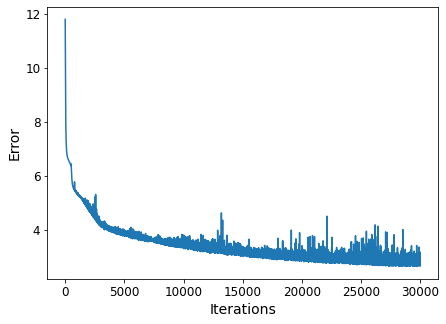

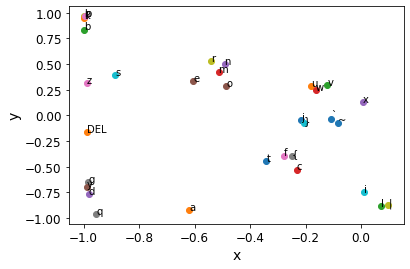

In [15]:
ret = []
latent_layer = 1
for h in range(0, len(Font3)):
    optimus.propagation(Font3[h], 0)
    optimus.calculate_exit()
    exit = []
    for i in optimus.exits:
        a = i["v"]
        if a >= 0.5:
            a = 1
        else:
            a = 0
        exit.append(a)
    ret.append([optimus.neurones[latent_layer][0]["v"], optimus.neurones[latent_layer][1]["v"]])
    print("\n-------------------------------------------------------------------------------------------\n")
    print("Character ->  \"", list(Font3_dict.keys())[list(Font3_dict.values()).index(Font3[h])], " \"\n")
    print("Input --> |\n", *printResult(Font3[h]), "|\n")
    print("Output -> |\n", *printResult(exit), "|\n")
    # print(Font3[h],"\n\n", exit)
graph_error(it, err)
graph_latent_space(ret)

In [16]:
def nava(x, y):
    optimus.decode(x, y)
    decodeExits = []
    for i in optimus.exits:
        a = i["v"]
        if a >= 0.5:
            a = 1
        else:
            a = 0
        decodeExits.append(a)
    print(*printResult(decodeExits))

In [17]:
p1 = [ret[19][0], ret[19][1]]
p2 = [ret[26][0], ret[26][1]]
x, y = getPoint(p1, p2)

nava(p1[0], p1[1])
nava(p2[0], p2[1])
nava(x, y)

          
           
   * * * * 
 *         
   * * *   
           
 * * * *   

          
           
 * * * * * 
       *   
     * *   
   *     * 
 * * * * * 

          
           
   * * * * 
           
   * * *   
           
 * * * * * 



In [7]:
def apply_noise(stimuli, probability):
    noises = (np.vectorize(
                lambda s: 1 - s if np.random.choice(a=[False, True], p=[1 - probability, probability]) else s)(stimuli))
    return noises

In [15]:
Font3_noise = []
probability = 0.1
for f in Font3:
    Font3_noise.append(apply_noise(f, probability))
for n in range(0, len(Font3_noise)):
    print(*printResult(Font3[n]))
    print(*printResult(Font3_noise[n]))
    print("-------------------")
    

    *     
     *     
       *   
           
           
           
           

  *       
 *         
       *   
     *   * 
           
         * 
           

-------------------
          
   * * *   
         * 
   * *   * 
 *     * * 
 *     * * 
   * *   * 

          
   * * *   
         * 
   * *   * 
 * *   * * 
   *   * * 
   * *   * 

-------------------
*         
 *         
 *         
 * * *     
 *     *   
 *     *   
 * * *     

    *   * 
 *         
 *         
 * * *     
 *     *   
 * *   *   
 * * *     

-------------------
          
           
           
   * * *   
 *         
 *         
   * * *   

        * 
           
           
   * * *   
 *       * 
         * 
   * * *   

-------------------
        * 
         * 
         * 
     * * * 
   *     * 
   *     * 
     * * * 

        * 
 *       * 
           
     *   * 
 * *     * 
   *     * 
     * * * 

-------------------
          
           
   * * *   
 *       * 
 * * * * * 
 

In [16]:
beta = 0.5
learningRate = 0.001
optimus = MultiLayerPerceptron(Font3_noise, Font3, learningRate, beta, structure)
w_min, it, err = optimus.run()

1000
175.60733200172476
2000
148.49844781310927
3000
135.30455696522515
4000
126.70811746605803
5000
123.01730515443052
6000
122.6990334515437
7000
121.77320166684049
8000
113.09426153959866
9000
111.56019932341897
10000
109.77287808817675
11000
108.75249178073263
12000
110.26765604072797
13000
106.56031689398199
14000
101.91884571128507
15000
101.50566907230265
16000
97.36113736003819
17000
96.67466396700412
18000
98.14635312823438
19000
99.63959419337279
20000
91.79477144603037
21000
101.22525976675142
22000
91.89626384031784
23000
89.86129604015333
24000
87.56989710317754
25000
86.3706823968564
26000
90.73637568575259
27000
83.27635863429578
28000
84.733751978422
29000
98.86131443493974
30000
81.74621782619961



-------------------------------------------------------------------------------------------

Character ->  " `  "

Input ----> |
   *       
 *         
       *   
     *   * 
           
         * 
           
 |

Output ---> |
           
     *     
       *   
           
           
           
           
 |

Correct --> |
     *     
     *     
       *   
           
           
           
           
 |

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

-------------------------------------------------------------------------------------------

Character ->  " a  "

Input ----> |
           
   * * *   
         * 
   * *   * 
 * *   * * 
   *   * * 
   * *   * 
 |

Output ---> |
           
       * * 
         * 
   * *   * 
 *     * * 
 *     * * 
   * *     
 |

Correct --> |
           
   * * *   
     

           
           
 *     *   
 * *     * 
 *         
 *         
 *         
 |

Correct --> |
           
           
 *   * *   
 * *     * 
 *         
 *         
 *         
 |

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0] 

 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]

-------------------------------------------------------------------------------------------

Character ->  " s  "

Input ----> |
     *     
           
   * * * * 
 *         
   * * *   
         * 
 * * * * * 
 |

Output ---> |
           
           
   * * * * 
 *         
   * * *   
         * 
 * * * *   
 |

Correct --> |
           
           
   * * * * 
 *         
   * * *   
         * 
 * * * *   
 |

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0] 

 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 

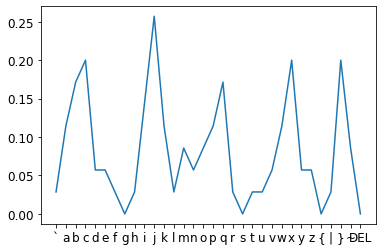

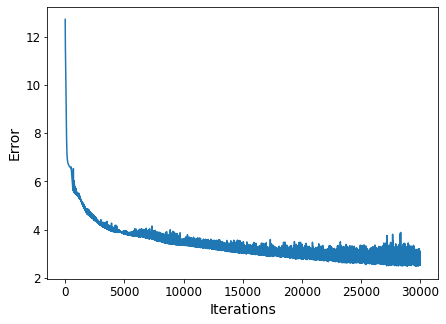

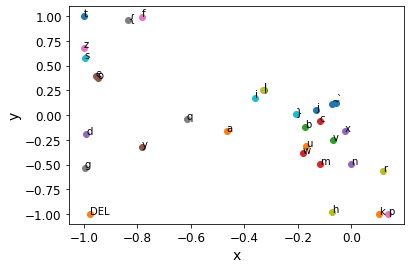

In [29]:
ret = []
latent_layer = 1
errors = []
for h in range(0, len(Font3_noise)):
    optimus.propagation(Font3_noise[h], 0)
    optimus.calculate_exit()
    exit = []
    for i in optimus.exits:
        a = i["v"]
        if a >= 0.5:
            a = 1
        else:
            a = 0
        exit.append(a)
    ret.append([optimus.neurones[latent_layer][0]["v"], optimus.neurones[latent_layer][1]["v"]])
    errors.append(np.sum(abs(np.array(exit) - np.array(Font3[h])), axis=0) / 35)
    #print("\n-------------------------------------------------------------------------------------------\n")
    #print("Character ->  \"", list(Font3_dict.keys())[list(Font3_dict.values()).index(Font3[h])], " \"\n")
    #print("Input ----> |\n", *printResult(Font3_noise[h]), "|\n")
    #print("Output ---> |\n", *printResult(exit), "|\n")
    #print("Correct --> |\n", *printResult(Font3[h]), "|\n")
    #print(Font3[h],"\n\n", exit)
plt.plot(chrs, errors)
graph_error(it, err)
graph_latent_space(ret)

1000
181.33459714440798
2000
170.67058038971166
3000
159.9282377990912
4000
149.2993633386629
5000
138.30048392488155
6000
130.8639473020616
7000
123.49594157366442
8000
117.22124966946062
9000
113.9628473309481
10000
113.41901844894151
11000
113.03114086166572
12000
118.60832203152493
13000
108.29433770551718
14000
117.77806083267899
15000
116.41876594447588
16000
104.04955073107011
17000
99.71342738024806
18000
106.74612116885761
19000
96.33397965712146
20000
93.04575044792631
21000
92.44687822543091
22000
98.0089210830353
23000
89.78505022827851
24000
99.00761754701499
25000
91.78299012442342
26000
92.05490899976138
27000
95.42498390016043
28000
106.42854904028636
29000
94.06058498109762
30000
87.10810931723847
1000
175.27606763257296
2000
162.12827542253828
3000
144.2201504911383
4000
132.10244710348343
5000
127.49833013115209
6000
122.82846404974008
7000
127.77157374571519
8000
117.30637408118585
9000
115.72578034944435
10000
110.67358706124398
11000
109.27635001654808
12000
113.1

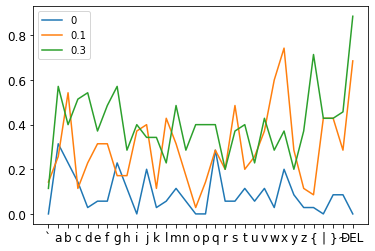

In [33]:
probability = [0, 0.1, 0.3]
beta = 0.5
learningRate = 0.001
for prob in probability:
    Font3_noise = []
    for f in Font3:
        Font3_noise.append(apply_noise(f, prob))
    optimus = MultiLayerPerceptron(Font3_noise, Font3, learningRate, beta, structure)
    w_min, it, err = optimus.run()
    errors = []
    Font3_noise = []
    for f in Font3:
        Font3_noise.append(apply_noise(f, prob))
    for h in range(0, len(Font3_noise)):
        optimus.propagation(Font3_noise[h], 0)
        optimus.calculate_exit()
        exit = []
        for i in optimus.exits:
            a = i["v"]
            if a >= 0.5:
                a = 1
            else:
                a = 0
            exit.append(a)
        errors.append(np.sum(abs(np.array(exit) - np.array(Font3[h])), axis=0) / 35)
        #print("\n-------------------------------------------------------------------------------------------\n")
        #print("Character ->  \"", list(Font3_dict.keys())[list(Font3_dict.values()).index(Font3[h])], " \"\n")
        #print("Input ----> |\n", *printResult(Font3_noise[h]), "|\n")
        #print("Output ---> |\n", *printResult(exit), "|\n")
        #print("Correct --> |\n", *printResult(Font3[h]), "|\n")
        #print(Font3[h],"\n\n", exit)
    plt.plot(chrs, errors, label=prob)
plt.legend()
plt.show()

In [ ]:
probability = [0, 0.1, 0.3]
beta = 0.5
learningRate = 0.001
for prob in probability:
    optimus = MultiLayerPerceptron(Font3, Font3, learningRate, beta, structure)
    w_min, it, err = optimus.runNoise(Font3, prob)
    errors = []
    Font3_noise = []
    for f in Font3:
        Font3_noise.append(apply_noise(f, prob))
    for h in range(0, len(Font3_noise)):
        optimus.propagation(Font3_noise[h], 0)
        optimus.calculate_exit()
        exit = []
        for i in optimus.exits:
            a = i["v"]
            if a >= 0.5:
                a = 1
            else:
                a = 0
            exit.append(a)
        errors.append(np.sum(abs(np.array(exit) - np.array(Font3[h])), axis=0) / 35)
        #print("\n-------------------------------------------------------------------------------------------\n")
        #print("Character ->  \"", list(Font3_dict.keys())[list(Font3_dict.values()).index(Font3[h])], " \"\n")
        #print("Input ----> |\n", *printResult(Font3_noise[h]), "|\n")
        #print("Output ---> |\n", *printResult(exit), "|\n")
        #print("Correct --> |\n", *printResult(Font3[h]), "|\n")
        #print(Font3[h],"\n\n", exit)
    plt.plot(chrs, errors, label=prob)
plt.legend()
plt.show()